In [17]:
import sys
sys.path.append('../implementation')
import numpy as np
import pandas as pd
import ast
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
import time
from util import flatten_list
from ottley_hidden_markov_model import HMM

In [26]:
underlying_data = pd.read_csv('../data/political/final/political.csv')
clean_id = [s.replace("p", "") for s in underlying_data['id']]
clean_id = [int(s.lstrip('0')) - 1 for s in clean_id]
underlying_data['id'] = clean_id
underlying_data = underlying_data.set_index('id')
output_file_path = '../output/political/political_hmm.pkl'

interaction_data = pd.read_csv('../data/political/final/wall_political_interactions.csv')
interaction_data['interaction_session'] = interaction_data.apply(lambda row: ast.literal_eval(row.interaction_session), axis=1)
interaction_data['interaction_type'] = interaction_data.apply(lambda row: ast.literal_eval(row.interaction_type), axis=1)
c_attrs = ['age', 'political_experience', 'policy_strength_ban_abortion_after_6_weeks', 
           'policy_strength_legalize_medical_marijuana', 'policy_strength_increase_medicare_funding',
          'policy_strength_ban_alcohol_sales_sundays']
d_attrs = ['party', 'gender', 'occupation']
ks = [1, 5, 10, 20, 50, 100]

In [27]:
underlying_data

,party,gender,first_name,last_name,occupation,age,political_experience,policy_strength_ban_abortion_after_6_weeks,policy_strength_legalize_medical_marijuana,policy_strength_increase_medicare_funding,policy_strength_ban_alcohol_sales_sundays
id,,,,,,,,,,,
128,Democrat,Female,Theda,Kim,Doctor,60,9,-3,-1,2,-3
49,Democrat,Female,Barbara,Oleary,Lawyer,60,9,-3,0,2,-3
73,Democrat,Female,Jill,Brunson,Career Politician,65,10,-3,0,2,-3
80,Democrat,Female,Debra,Thomas,Scientist,51,9,-3,0,2,-3
168,Democrat,Male,Ralph,Odell,Business,56,7,-3,1,0,-3
...,...,...,...,...,...,...,...,...,...,...,...
48,Republican,Male,Anthony,Luce,Lawyer,75,6,3,-2,-1,3
151,Republican,Female,Barbara,Bechtel,Business,51,5,3,-2,-1,3
114,Republican,Male,Dallas,Rudy,Career Politician,58,8,3,-2,-1,3


In [29]:
bookmarks_per_user = {}
committees_per_user = {
    'ZY1tfYLxtiya': [81, 140, 12, 35, 70, 115, 50, 30, 42, 2],
    'r9cpBWj7l0iV': [59, 12, 138, 26, 94, 115, 106, 139, 39, 74],
    '8D64yb05oRDt': [86, 81, 140, 13, 30, 35, 42, 12, 3, 119],
    'CnOeEROhOZaX': [29, 58, 36, 119, 141, 122, 50, 105, 72, 70],
    'qFIltQnZAor7': [65, 105, 50, 92, 116, 58, 23, 70, 93, 119],
    'gPCb7Uy0pEM0': [80, 94, 3, 98, 122, 0, 141, 12, 23, 105],
    '6oheLF74hlXc': [141, 105, 22, 93, 115, 88, 122, 21, 5, 57],
    'xrOuOynQhVbO': [93, 73, 6, 72, 64, 102, 11, 119, 99, 78],
    'lPpxNz1aVtYh': [42, 2, 122, 105, 119, 78, 20, 140, 65, 141],
    '8cPi4CoiSpNN': [130, 42, 2, 141, 134, 36, 18, 59, 96, 58],
    'hoMzF8Cf1Y5j': [70, 81, 42, 92, 50, 134, 115, 86, 17, 2],
    '3Sp3rSvqFsh6': [12, 50, 140, 35, 46, 122, 36, 86, 70, 42]
}

for participant_index, row in interaction_data.iterrows():
    print(f'Processing user {row.user}')
    interactions = interaction_data.loc[participant_index].interaction_session
    bookmarks_per_user[row.user] = underlying_data.loc[interactions].copy()
    bookmarks_per_user[row.user]['in_committee'] = bookmarks_per_user[row.user].apply(lambda r: r.name in committees_per_user[row.user], axis=1)
    


Processing user lPpxNz1aVtYh
Processing user xrOuOynQhVbO
Processing user 6oheLF74hlXc
Processing user 8cPi4CoiSpNN
Processing user hoMzF8Cf1Y5j
Processing user gPCb7Uy0pEM0
Processing user 3Sp3rSvqFsh6
Processing user qFIltQnZAor7
Processing user CnOeEROhOZaX
Processing user 8D64yb05oRDt
Processing user r9cpBWj7l0iV
Processing user ZY1tfYLxtiya


In [33]:
for i in bookmarks_per_user:
    bookmarks_per_user[i].to_csv(f'../output/political/session_bookmarks/{i}.csv')

In [35]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'political_experience'}>],
       [<AxesSubplot:title={'center':'policy_strength_ban_abortion_after_6_weeks'}>,
        <AxesSubplot:title={'center':'policy_strength_legalize_medical_marijuana'}>],
       [<AxesSubplot:title={'center':'policy_strength_increase_medicare_funding'}>,
        <AxesSubplot:title={'center':'policy_strength_ban_alcohol_sales_sundays'}>]],
      dtype=object)

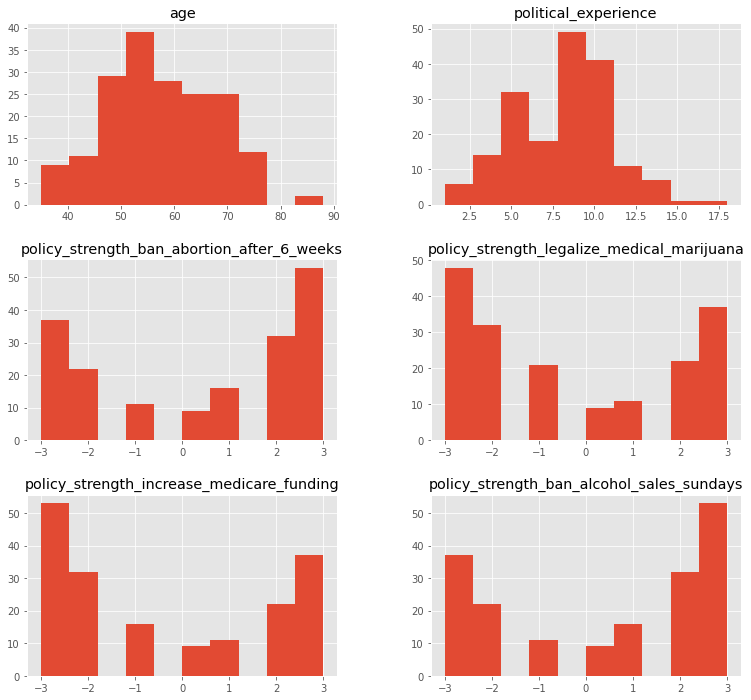

In [46]:
underlying_data.hist(figsize=(2*6.4, 3*4))

Text(0.5, 1.0, 'party')

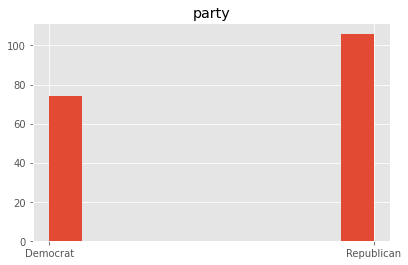

In [50]:
underlying_data.party.hist(figsize=(1*6.4, 1*4))
plt.title('party')

Text(0.5, 1.0, 'gender')

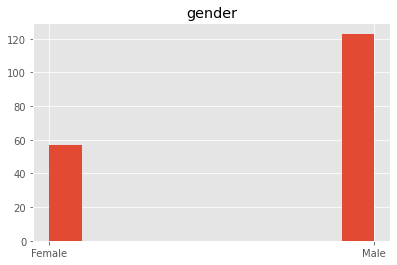

In [51]:
underlying_data.gender.hist(figsize=(1*6.4, 1*4))
plt.title('gender')

Text(0.5, 1.0, 'occupation')

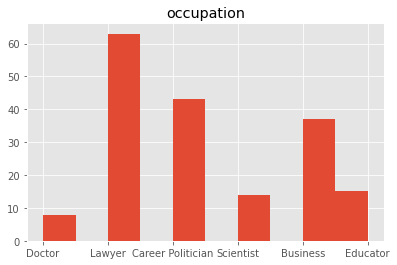

In [52]:
underlying_data.occupation.hist(figsize=(1*6.4, 1*4))
plt.title('occupation')